# Clasificación de Imágenes con ML
Bosco Domingo Benito, Luis De Marcos Mazarío 





# Imports y variables globales

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import csv
import random
from skimage import data, exposure, img_as_float, filters, io
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from skimage.color import rgb2gray
import tensorflow as tf
from collections import Counter

random_state = 1337
random.seed(random_state)
IMG_WIDTH=150
IMG_HEIGHT=150
target_dict = {'edificios':0,'bosques':1,'glaciares':2,'montañas':3,'mares':4,'calles':5}

# Helpers

In [3]:
def select_random_picture(dir):
    return os.path.join(dir, random.choice(os.listdir(dir)))

def plot_random_picture(dir, number_of_pictures, grayscale= False, grayscale_pair = False, filter="", radius=5):
    """Plots a number of pseudo-randomly picked images, with the option to show them in grayscale
    and/or accompanied by a grayscale version and/or a filtered version.
    Allowed filters: 'sobel', 'unsharp_mask', 'median', 'hessian', 'threshold_mean', 'threshold_otsu',
    'laplace', 'frangi', 'meijering', 'scharr'
    If the filter is unsharp_mask, radius can be used
    Returns the images displayed
    """
    plotted_images = []
    additional_number_pictures = int(grayscale_pair) + int(filter != "")
    number_of_pictures = number_of_pictures*(1 + additional_number_pictures)
    fig, axes = plt.subplots(ncols=number_of_pictures, figsize=(5*number_of_pictures, 5*number_of_pictures))
    step = 1 + additional_number_pictures 
    for i in range(0, number_of_pictures, step):
        image = io.imread(select_random_picture(dir))
        plotted_images.append(image)
        if grayscale:
            image = rgb2gray(image)
            axes[i].imshow(rgb2gray(image), cmap='gray')
        else: axes[i].imshow(image)

        if grayscale_pair and not grayscale:
            axes[i+1].imshow(rgb2gray(image), cmap='gray')

        if filter == 'sobel':
            axes[i+1+int(grayscale_pair)].imshow(filters.sobel(image))
        elif filter == 'unsharp_mask':
            axes[i+1+int(grayscale_pair)].imshow(filters.unsharp_mask(image, radius=radius))
        elif filter == 'median':
            axes[i+1+int(grayscale_pair)].imshow(filters.median(image))
        elif filter == 'hessian':
            axes[i+1+int(grayscale_pair)].imshow(filters.hessian(image))
        elif filter == 'threshold_mean':
            axes[i+1+int(grayscale_pair)].imshow(image > filters.threshold_mean(image))
        elif filter == 'threshold_otsu':
            axes[i+1+int(grayscale_pair)].imshow(image > filters.threshold_otsu(image))
        elif filter == 'laplace':
            axes[i+1+int(grayscale_pair)].imshow(filters.laplace(image))
        elif filter == 'frangi':
            axes[i+1+int(grayscale_pair)].imshow(filters.frangi(image))
        elif filter == 'meijering':
            axes[i+1+int(grayscale_pair)].imshow(filters.meijering(image))
        elif filter == 'scharr':
            axes[i+1+int(grayscale_pair)].imshow(filters.scharr(image))
        elif filter == 'gabor':
            axes[i+1+int(grayscale_pair)].imshow(filters.gabor(image, frequency=0.58)[0])

        
    axes[round((number_of_pictures+0.000000001)/2)-1].set_title(dir.split('/')[-1])
    plt.show()
    return plotted_images

def plot_histogram(array):
    fig = plt.figure(figsize=(5*len(array), 5))
    ax = fig.subplots(ncols=len(array))
    for i in range(0, len(array)):
        ax[i].hist(array[i].ravel(), bins=255)

def prepare_dataset(dir, tag, grayscale = False, scale_exposure = True, filter="", radius=5, verbose = False):
    """Loads the images found in the directory folder into the X array, optionally grayscaling them
    and rescaling their exposure if needed and indicated, as well as applying one of many filters.
    Stores the corresponding tags in y,
    Returns X,y
    
    Allowed filters: 'sobel', 'unsharp_mask', 'median', 'hessian', 'threshold_mean', 'threshold_otsu',
    'laplace', 'frangi', 'meijering', 'scharr'
    If the filter is unsharp_mask, radius can be used
    """
    rejected_images = 0
    X,y = [],[]
    for img_path in os.listdir(dir):
        image = io.imread(os.path.join(dir,img_path))
        if image.shape != (IMG_HEIGHT, IMG_WIDTH, 3):
            rejected_images += 1
            continue
        if grayscale:
            image = rgb2gray(image)
            if image.max()==255 and image.min() == 0 and scale_exposure:
                image = exposure.rescale_intensity(image, in_range=(0, 255))
    
        if filter == 'sobel':
            image = filters.sobel(image)
        elif filter == 'unsharp_mask':
            image = filters.unsharp_mask(image, radius=radius)
        elif filter == 'median':
            image = filters.median(image)
        elif filter == 'hessian':
            image = filters.hessian(image)
        elif filter == 'threshold_mean':
            image = image > filters.threshold_mean(image)
        elif filter == 'threshold_otsu':
            image = image > filters.threshold_otsu(image)
        elif filter == 'laplace':
            image = filters.laplace(image)
        elif filter == 'frangi':
            image = filters.frangi(image)
        elif filter == 'meijering':
            image = filters.meijering(image)
        elif filter == 'scharr':
            image = filters.scharr(image)
        elif filter == 'gabor':
            image = filters.gabor(image, 0.58)[0]

        X.append(image.reshape(-1))
        y.append(tag)
    if verbose:
        print(f"Rejected {rejected_images} images from directory {dir} using filter {filter}")
    return (X,y)

# Lectura de datos

Lo primero que hacemos es cargar las imágenes de Github al Colab. **Será necesaria la ejecución de este comando para la carga de los datos**

Se ha realizado una limpieza poco exhaustiva a mano de las fotos, eliminando las que fuesen muy discrepantes 

In [4]:
!npx degit LuisDeMarcos/p2-images -f 

npx: installed 1 in 1.632s
> destination directory is not empty. Using --force, continuing
> cloned LuisDeMarcos/p2-images#master


# Análisis inicial y representación de los datos

Comparamos 2 fotos de cada tipo en color y su versión en blanco y negro, a fin de decidir de manera empírica si parecen seguir un patrón observable y cuán útil puede ser el color de cara a la clasificación para los modelos

In [ ]:
plotted_images = []
for dir in target_dict.keys():
    plotted_images.append(plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale_pair=True))

Y ploteamos los histogramas correspondientes a cada imagen en blanco y negro, en orden:

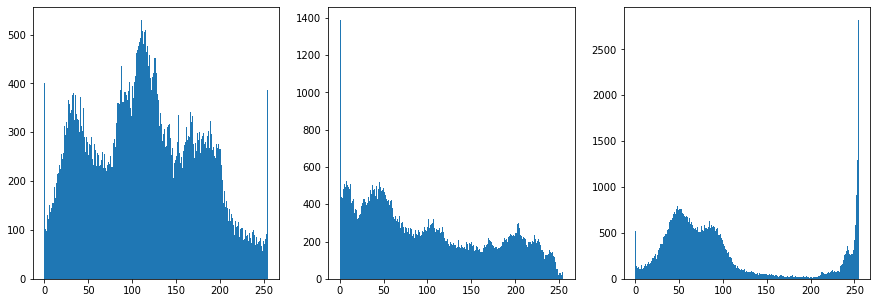

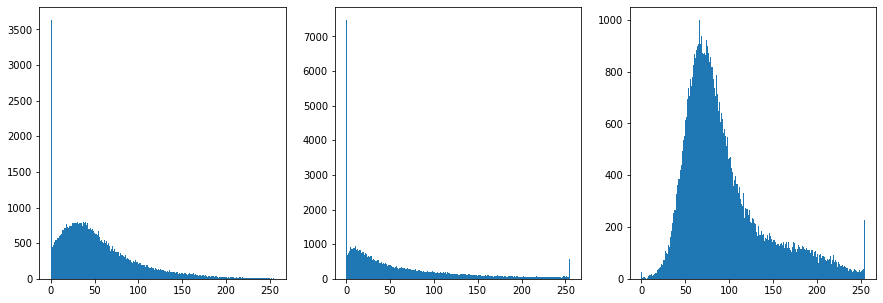

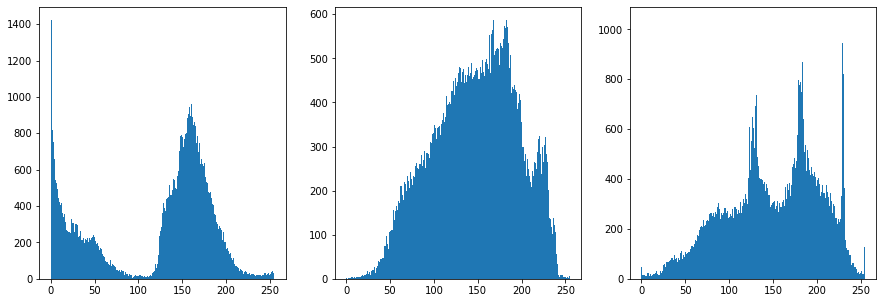

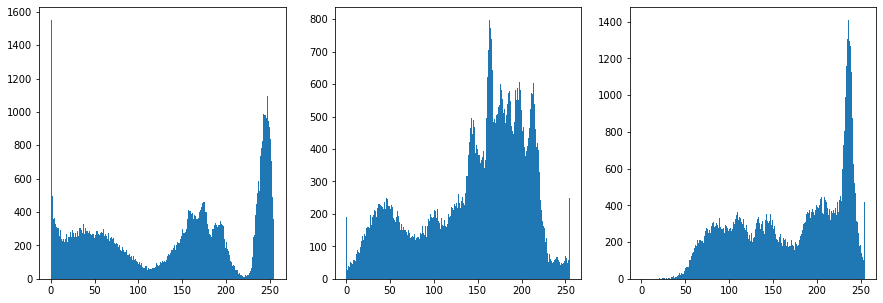

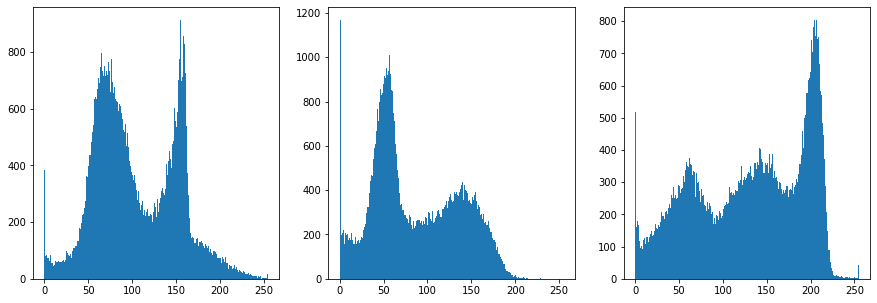

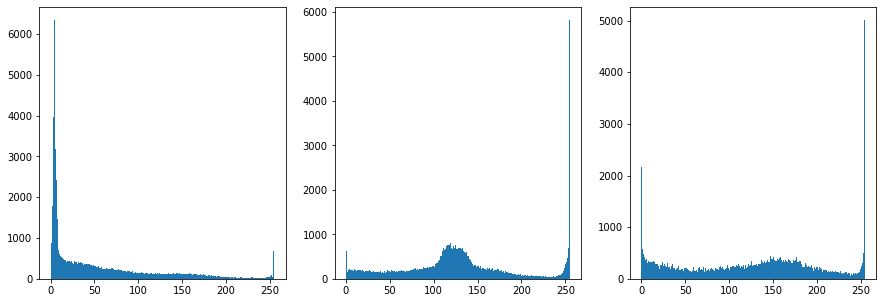

In [ ]:
    for category in plotted_images:
        plot_histogram(category)

# Decisiones de partida
Nos decantamos por usar imágenes en blanco y negro, puesto que las fotos a color para este dataset aportan una información que no consideramos que merezca la pena debido a la enorme carga computacional que añade.

Pese a la dominancia del azul y blanco en los glaciares, del verde y marrón de los bosques... observado en un gran número de casos (que por limitaciones de pantalla y procesamiento no mostramos, pero es también apreciable sobre las mostradas arriba) *y que puede ser una característica determinante*, hay también un elevado número de muestras que no presentan esas características, y que de hecho podrían llevar al modelo a falsos negativos por no poseer el color. **Queremos evitar este sesgo**.

Dicho eso, no descartamos la posible utilización de fotos a color en el futuro si comprobamos que en efecto, el color es un factor crucial en la correcta clasificación de imágenes.

Además, observamos que en muchos casos, **hay ciertas similitudes entre las formas de los histogramas** que también puede ser interesante analizar.

En cuanto a transformaciones y traslaciones, no vemos utilidad puesto que la idea es que reconozca formas dentro de la imagen, y eliminar píxeles de los bordes, rotarla, reescalarla... no aportarían nada, en especial si todas las imágenes tienen la misma orientación y tamaño y tienen información importante no concentrada sólo en el centro

# Entrenamiento y Predicción con Fotos en Blanco y Negro (Grayscale)

Escogemos muestras aleatorias de 5 imágenes de cada clase para aplicar un filtro global a todas que, de manera empírica, resalte las distintas características de cada una, y nos decantamos por un set inicial de filtros con el que jugar (si tuviéramos más tiempo probaríamos todos los filtros)

### Filtros
Elegimos métodos que creemos pueden resaltar las diferencias entre los distintos elementos, puesto que en ausencia de color las formas y sombras serán las características más determinantes.

En un contexto más riguroso y científico el primer paso sería contar con expertos en imágenes y los filtros que vamos a emplear. En este caso, por falta de conocimiento y ser un campo que al fin y al cabo, es externo al alcance de esta asignatura, optaremos por probar múltiples filtros de forma manual y observar cuál obtiene mejores resultados. Podemos hacer unas ciertas predicciones de dichos resultados en base a las imágenes obtenidas, pero no serán más que "*educated guesses*"

#### Sobel

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='sobel')

Output hidden; open in https://colab.research.google.com to view.

#### Unsharp Mask
> Permite resaltar los bordes de la imagen y desenfocar las zonas sin bordes:

In [ ]:
radius = 5.5  #@param {type:"slider", min:0.5, max:100, step:0.5}
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='unsharp_mask', radius=radius)

Output hidden; open in https://colab.research.google.com to view.

#### Median
> "Aplana" una imagen calculando el valor medio local de cada pixel:

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='median')

Output hidden; open in https://colab.research.google.com to view.

#### Hessian

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='hessian')

Output hidden; open in https://colab.research.google.com to view.

#### Umbral

> Otra tendencia habitual es binarizar los datos de tal forma que cada píxel tome el valor blanco o negro. Para ello, se establece un umbral (*threshold*) a patir del cual el píxel se asume como fondo o no. Existen diferentes algoritmos para determinar el umbral y podemos ver sus diferencias con [`try_all_threshold`](https://scikit-image.org/docs/stable/api/skimage.filters.html#try-all-threshold):

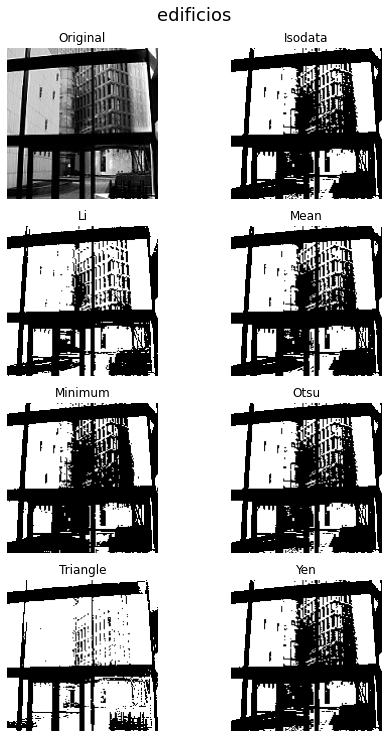

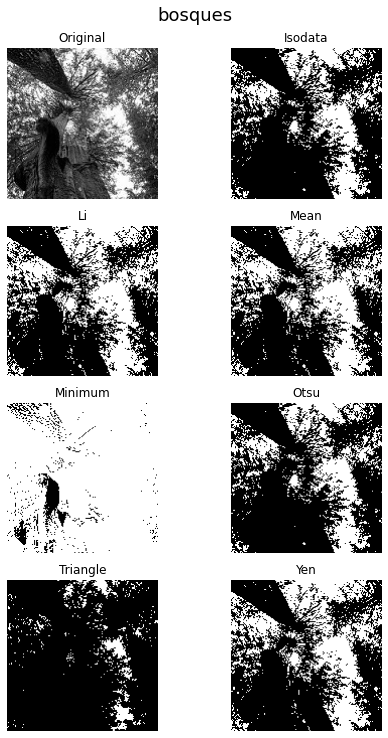

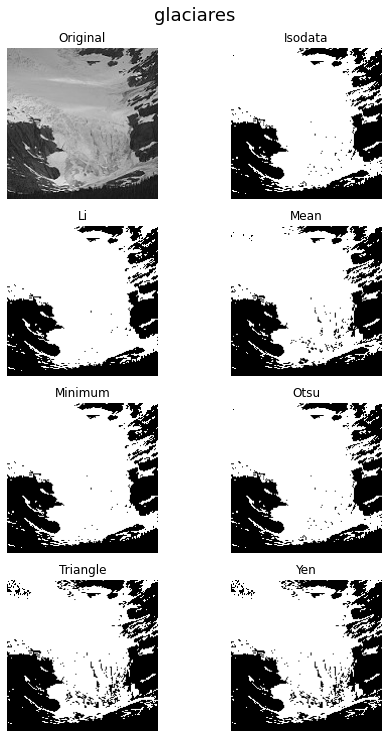

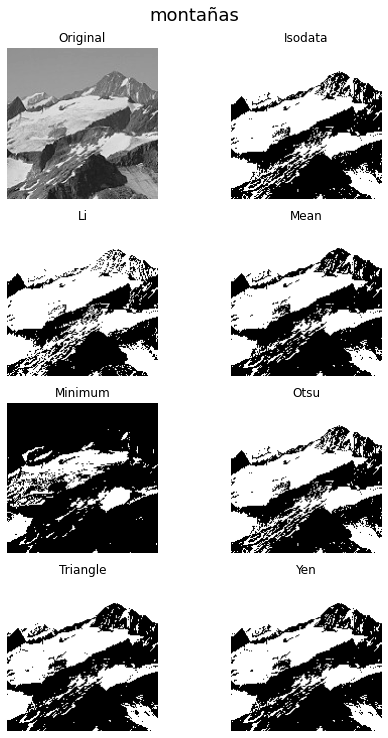

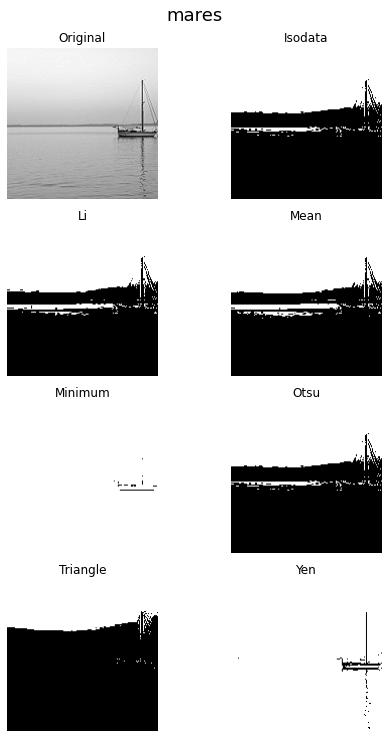

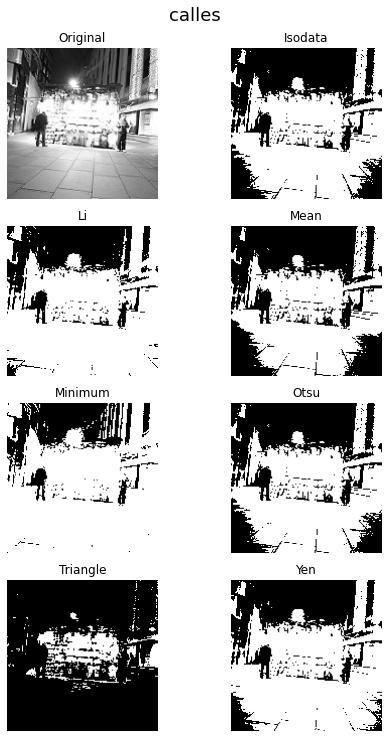

In [ ]:
for dir in target_dict.keys():
    image = rgb2gray(io.imread(select_random_picture(os.path.join('train_filtered', dir))))
    fig, ax = filters.try_all_threshold(image, figsize=(10, 10), verbose=False)
    fig.suptitle(dir, fontsize=18, y = 1.02)
    plt.tight_layout()
    plt.show()

#### Laplace

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='laplace')

Output hidden; open in https://colab.research.google.com to view.

#### Frangi

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='frangi')

Output hidden; open in https://colab.research.google.com to view.

#### Meijering

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='meijering')

Output hidden; open in https://colab.research.google.com to view.

#### Scharr

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='scharr')

Output hidden; open in https://colab.research.google.com to view.

#### Gabor
>Gabor filter is a linear filter with a Gaussian kernel which is modulated by a sinusoidal plane wave. Frequency and orientation representations of the Gabor filter are similar to those of the human visual system. Gabor filter banks are commonly used in computer vision and image processing. They are especially suitable for edge detection and texture classification.

In [ ]:
for dir in target_dict.keys():
    plot_random_picture(os.path.join('train_filtered', dir), 3, grayscale=True, filter='gabor')

Output hidden; open in https://colab.research.google.com to view.

## Obtención de datasets básicos


Uno de los primeros pasos para resaltar las diferencias entre diferentes formas en cada foto será el de **reescalar la exposición** de aquellas que no tengan como máximo y mínimo el 255 y 0 respectivamente, y aprovechamos para **quitar todas aquellas que no cumplan con las medidas deseadas de 150x150**

In [ ]:
X_train = []
y_train = []
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, scale_exposure= True)
    X_train.extend(X)
    y_train.extend(y)
print(len(X_train), len(y_train)) # 14034 - rejected (=13986) should be the number of pictures

13922 13922


In [ ]:
X_test = []
y_test = []
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, scale_exposure= True)
    X_test.extend(X)
    y_test.extend(y)
print(len(X_test), len(y_test)) # 3000 - rejected (=2993) should be the number of pictures

2993 2993


## Modelos Machine Learning


### Scoring

Se va a utilizar el ***F1 score* como métrica general** para comparar modelos entre sí, así como **matrices de confusión** y ***accuracy***, ***precision*** y ***recall***.

No usaremos *ROC Curve* puesto que requeriría hacer un caso de *one-against-all* para cada clase, y las métricas anteriores ya nos proveen suficiente información

---
### RandomForest con Grayscale

In [ ]:
#Barebones Random Forest
rf_grayscale = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale.fit(np.asarray(X_train),np.asarray(y_train))

In [ ]:
predictions = rf_grayscale.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5208304557373967
Accuracy: 0.5289007684597394
Precision: 0.5264531106676206
Recall: 0.5270337163604847
Confusion matrix:
 [[160  79  62  39  38  59]
 [ 29 347  25   6   7  59]
 [ 37  37 297  86  62  30]
 [ 25  27  63 320  72  16]
 [ 36  45 129  97 186  17]
 [ 53 102  51  15   7 273]]


----
### RandomForest GridSearchCV con Grayscale
**IMPORTANTE** NO EJECUTAR ESTAS CELDAS EN LA DEMO. Tardan mucho (varias horas) y las celdas cuentan ya con los resultados.

Usamos GridSearchCV para encontrar los mejores hiperparámetros, pero como se puede comprobar, el dataset es demasiado grande para ejecutarlo entero y por ende lo tenemos que partir, eligiendo un subset aleatorio de fotos

In [ ]:
#Select 6000 random indeces due to hardware limitations
X_train_randomised, y_train_randomised = ([],[])
for i in range(6000):
    random_index = random.randint(0, len(X_train)-1)
    X_train_randomised.append(X_train[random_index])
    y_train_randomised.append(y_train[random_index])
print(Counter(y_train_randomised)) #To ensure a somewhat even distribution

Counter({3: 1056, 2: 1019, 5: 1016, 1: 987, 4: 975, 0: 947})


In [ ]:
parameters = {
    'n_estimators' : [200, 250],
    'max_depth' : [None],
    'random_state' : [random_state],
    'criterion' : ['gini', 'entropy'],
    'n_jobs': [-1]
}
rf_grayscale_CV = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, scoring = 'f1_macro', cv=5)

Nota: Tarda una enorme cantidad de tiempo, y no queremos segar el dataset más, ergo por limitaciones de hardware nos contentamos con los intentos realizados de obtener un mejor resultado

In [ ]:
with tf.device('/device:GPU:0'):
    rf_grayscale_CV.fit(X_train_randomised, y_train_randomised)

In [ ]:
rf_grayscale_CV.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 1337}

In [ ]:
predictions = rf_grayscale_CV.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5208304557373967
Accuracy: 0.5289007684597394
Precision: 0.5264531106676206
Recall: 0.5270337163604847
Confusion matrix:
 [[160  79  62  39  38  59]
 [ 29 347  25   6   7  59]
 [ 37  37 297  86  62  30]
 [ 25  27  63 320  72  16]
 [ 36  45 129  97 186  17]
 [ 53 102  51  15   7 273]]


Para el resto de pruebas, emplearemos el RandomForest por defecto, que da unos resultados mejores que los que hemos logrado conseguir con GridSearchCV, y es más rápido

---
### RandomForest con Grayscale + Sobel

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'sobel'

for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_sobel = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_sobel.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_sobel.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5006263913973532
Accuracy: 0.5071834279986636
Precision: 0.5029445930847619
Recall: 0.5118186372568084
Confusion matrix:
 [[199  47  47  40  26  78]
 [  6 414   7   3   5  38]
 [ 37  39 235 124  52  62]
 [ 40   9 119 247  93  15]
 [ 22  32 125 184 124  23]
 [ 49  76  47  16  14 299]]


---
### RandomForest con Grayscale + Unsharp Mask


In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'unsharp_mask'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_unsharp = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_unsharp.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_unsharp.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.511327175314121
Accuracy: 0.5215502839959907
Precision: 0.5175871846660657
Recall: 0.5200466658652356
Confusion matrix:
 [[140  73  59  55  39  71]
 [ 24 375  17   4   1  52]
 [ 34  40 272  96  71  36]
 [ 29  16  64 313  84  17]
 [ 25  43 128 101 198  15]
 [ 42 119  49  20   8 263]]


---
### RandomForest con Grayscale + Median

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'median'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_median = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_median.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_median.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5247211409851618
Accuracy: 0.5315736719011026
Precision: 0.5281800747720218
Recall: 0.5298906070171898
Confusion matrix:
 [[164  66  54  51  38  64]
 [ 35 340  21   9  10  58]
 [ 29  35 295  80  84  26]
 [ 27  37  64 313  64  18]
 [ 37  55 133  83 189  13]
 [ 55  77  49  22   8 290]]


---
### RandomForest con Grayscale + Hessian

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'hessian'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_hessian = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_hessian.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_hessian.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.4917770914873673
Accuracy: 0.5001670564650852
Precision: 0.4930468013252505
Recall: 0.4997876045810164
Confusion matrix:
 [[138  54  69  54  33  89]
 [  6 359  20  16  12  60]
 [ 55  40 239 101  71  43]
 [ 41  21  78 283  77  23]
 [ 39  49 120  90 187  25]
 [ 44  88  40  25  13 291]]


---
### RandomForest con Grayscale + Umbral (Mean)

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'threshold_mean'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_thresh_mean = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_thresh_mean.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_thresh_mean.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.4952739665576107
Accuracy: 0.5005011693952556
Precision: 0.49583228770628757
Recall: 0.4998035162504064
Confusion matrix:
 [[159  70  56  33  47  72]
 [ 31 333  13   4   1  91]
 [ 48  35 248  80  91  47]
 [ 23  11  84 318  73  14]
 [ 45  28 120  89 200  28]
 [ 53 111  61  20  16 240]]


---
### RandomForest con Grayscale + Umbral (Otsu)

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'threshold_otsu'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_thresh_otsu = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_thresh_otsu.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_thresh_otsu.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5005403731663146
Accuracy: 0.5068493150684932
Precision: 0.49935609598674086
Recall: 0.5065243891526113
Confusion matrix:
 [[161  54  69  34  49  70]
 [ 26 353  11   3   3  77]
 [ 48  31 257  86  84  43]
 [ 43  15  64 310  76  15]
 [ 51  34 106  99 190  30]
 [ 64 104  55  19  13 246]]


---
### RandomForest con Grayscale + Laplace

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'laplace'
for class_name, tag in target_dict.items():
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_laplace = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_laplace.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_laplace.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.43026369588718555
Accuracy: 0.45105245573003677
Precision: 0.4405637117686532
Recall: 0.45269836668080554
Confusion matrix:
 [[ 97  68  80  83  16  93]
 [  3 438   3   2   2  25]
 [ 44  57 196 137  27  88]
 [ 38  16  99 236 108  26]
 [ 23  40  93 180 128  46]
 [ 34 132  49  22   9 255]]


---
### RandomForest con Grayscale + Frangi

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'frangi'
for class_name, tag in target_dict.items():
    print(class_name)
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_frangi = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_frangi.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_frangi.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5334832771748891
Accuracy: 0.5392582692950217
Precision: 0.5374517085361138
Recall: 0.539050712207397
Confusion matrix:
 [[172  62  55  38  31  79]
 [ 19 362  18   7   5  62]
 [ 32  36 276  99  66  40]
 [ 29  29  79 293  76  17]
 [ 34  41 107  93 214  21]
 [ 47  92  37  21   7 297]]


---
### RandomForest con Grayscale + Meijering

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'meijering'
for class_name, tag in target_dict.items():
    print(class_name)
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
rf_grayscale_meijering = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_meijering.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_meijering.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.535609716896571
Accuracy: 0.5425993985967257
Precision: 0.5393112396009373
Recall: 0.5436228244667501
Confusion matrix:
 [[180  56  51  41  37  72]
 [  9 386   9   6   2  61]
 [ 46  45 261 100  57  40]
 [ 32  35  69 301  69  17]
 [ 42  50  96  92 204  26]
 [ 41  88  52  16  12 292]]


---
### RandomForest con Grayscale + Scharr

In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'scharr'
for class_name, tag in target_dict.items():
    print(class_name)
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

In [ ]:
rf_grayscale_scharr = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_scharr.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_scharr.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5094337176331797
Accuracy: 0.5148680253925827
Precision: 0.5150066708037485
Recall: 0.5193872783291762
Confusion matrix:
 [[199  49  48  48  18  75]
 [  3 419   3   5   4  39]
 [ 46  41 238 126  47  51]
 [ 27   9 125 247  95  20]
 [ 25  34 112 179 140  20]
 [ 42  77  48  23  13 298]]


----
### RandomForest con Grayscale + Gabor


In [ ]:
del X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = [], [], [], []
filter = 'gabor'
for class_name, tag in target_dict.items():
    print(class_name)
    X, y = prepare_dataset(os.path.join('train_filtered', class_name), tag, grayscale= True, filter=filter)
    X_train.extend(X)
    y_train.extend(y)
    X, y = prepare_dataset(os.path.join('test', class_name), tag, grayscale= True, filter=filter)
    X_test.extend(X)
    y_test.extend(y)

edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
rf_grayscale_gabor = RandomForestClassifier(random_state=random_state)
with tf.device('/device:GPU:0'):
    rf_grayscale_gabor.fit(X_train,y_train)

In [ ]:
predictions = rf_grayscale_gabor.predict(X_test)
print("F1 Score:", f1_score(y_test, predictions, average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
print("Confusion matrix:\n", confusion_matrix(y_test, predictions))

F1 Score: 0.5679712601802532
Accuracy: 0.5790177079852991
Precision: 0.5773414624154712
Recall: 0.5781870779211757
Confusion matrix:
 [[153  72  59  73  16  64]
 [  7 439   0   1   1  25]
 [ 30  27 294  97  59  42]
 [ 41   4  65 325  76  12]
 [ 20  12 109 130 226  13]
 [ 36 110  40  12   7 296]]


## Conclusión:

Nuestro mejor modelo ha sido el que emplea el filtro ```gabor``` con frecuencia 0.58

Visto lo visto, los modelos no parecen encontrar ninguna segregación que les permita clasificar de forma fiable las imágenes. Pese a probar con múltiples filtros, no son capaces de identificar formas o relieves característicos de una u otra clase. Muy probablemente la falta de color sea un factor determinístico, y es más que probable que las imágenes entre sí no sean lo suficientemente parecidas dentro de una clase y excesivamente similares entre distintas clases como para hallar patrones numéricos que el modelo pueda comprender (la mayor similitud está entre mares y glaciares, que es fácilmente observable a ojo).

Nuestra hipótesis inicial, por tanto, queda rechazada y nuestra sospecha de que el color podría ser demasiado importante cobra fuerza.

Procedemos a comprobar si con colores el resultado logra mejorar.

---
# Entrenamiento y Predicción con Fotos a Color

Una vez probados los modelos a base de imágenes en blanco y negro, procedemos a entrenar modelos con imágenes a color. El color de la imagen aportará información que las de blanco y negro no pueden, y nos será útil para las imágenes cuya forma no sea clara. Se han tenido en cuenta 3 posibilidades: paleta de colores, color promedio e histrogramas.

Estos filtros se aplicarán sólo para aquellas imágenes que no estén en escala de grises, puesto que modificaría el modelo a entrenar.

## Histograma de Color

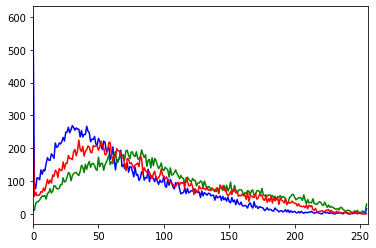

In [ ]:
histr = []
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('train/bosques/10030.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
#IMAGE PROCESSING
print('Processing...')

histr_rgb = [[],[],[]]
NUM_IMG = 1000
color = ('b','g','r')

for img_class in target_dict:
  print(img_class)
  img_count = 0
  for jpg in os.listdir(f'train_filtered/{img_class}'):
    
    try:
      img = cv2.imread(f'train_filtered/{img_class}/{jpg}')
    except:
      continue

    if img.shape != (150,150,3):
      continue

    if img_count == NUM_IMG:
      break
      
    img_count += 1

    for i,col in enumerate(color):
      histr = cv2.calcHist([img],[i],None,[256],[0,256])
      for i in range(3):
        histr_rgb[i].append(np.append(histr.flatten(), [target_dict[img_class]]))

columns = [x for x in range(256)]+['class']
df_histr = [pd.DataFrame(data=histr_rgb[0], columns=columns),pd.DataFrame(data=histr_rgb[1], columns=columns),pd.DataFrame(data=histr_rgb[2], columns=columns)]

#TRAINING
print('Training...')

rf_histr_rgb = [RandomForestClassifier() for x in range(3)] 

for i in range(3):
  rf_histr_rgb[i].fit(df_histr[i].iloc[:,:-1],df_histr[i]['class'])

#TESTING
print('Testing...')

histr_preds = []
histr_test = []

for img_class in target_dict:
  print(img_class)
  img_count = 0
  for jpg in os.listdir(f'test/{img_class}'):
      if img_count == 200:
        break
      img_count+=1
      img = cv2.imread(f'test/{img_class}/{jpg}')

      histr_predictions = [0 for x in range(6)]
      for i in range(3):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        histr_predictions += rf_histr_rgb[i].predict_proba([histr.flatten()])

      histr_preds.append(np.where(histr_predictions == np.amax(histr_predictions))[1][0])

      histr_test.append(target_dict[img_class])

f1_score(histr_test,histr_preds, average='macro')

edificios
bosques
glaciares
montañas
mares
calles
edificios
bosques
glaciares
montañas
mares
calles


0.37117167003619594

## Color Promedio (KNN)

Usaremos el color promedio de la imagen y un ensemble KNN

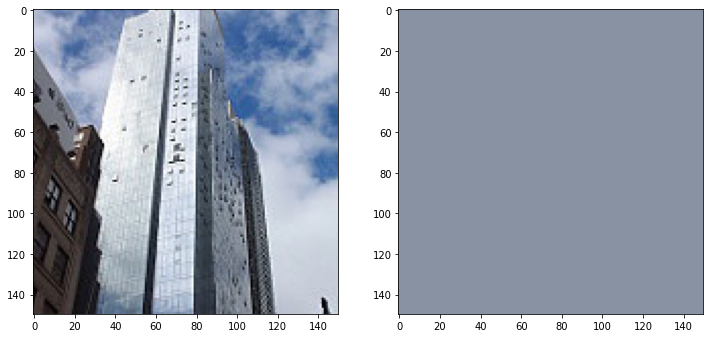

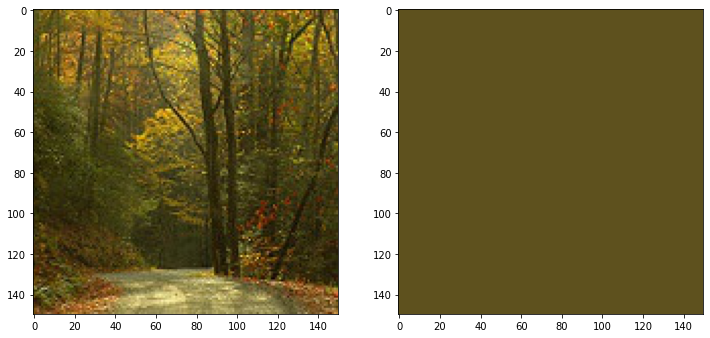

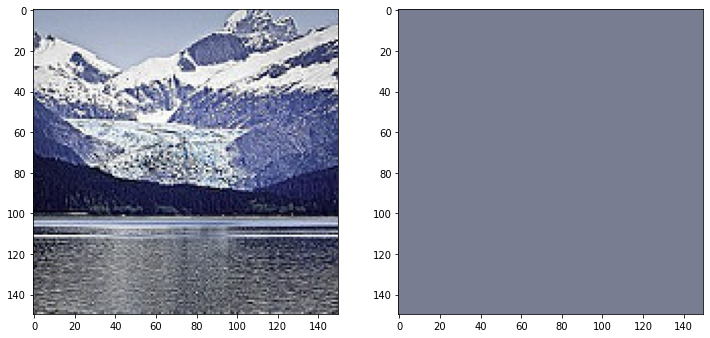

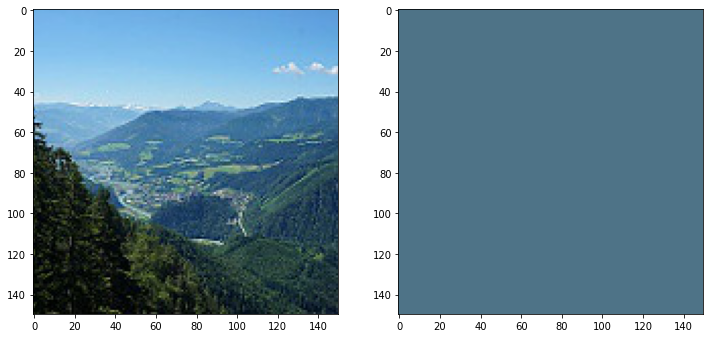

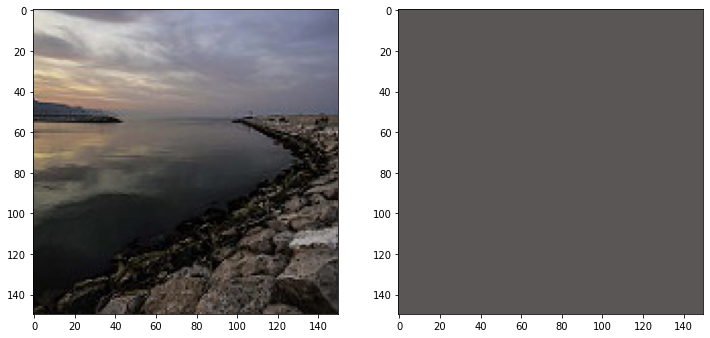

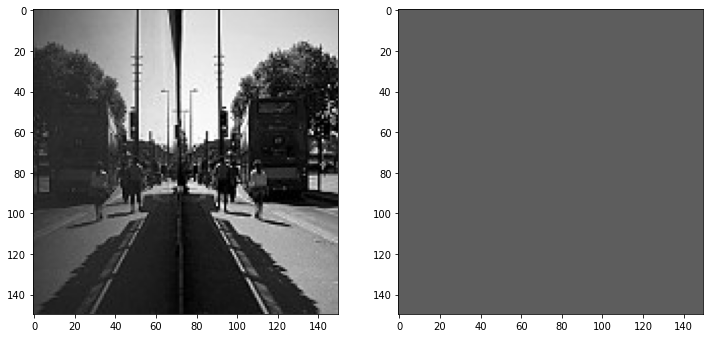

In [ ]:
# IMG - AVERAGE
for img_class in target_dict:
  for x in range(1):
    img = io.imread(select_random_picture(os.path.join('train_filtered', img_class)))

    average = img.mean(axis=1).mean(axis=0)
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,9))
    ax0.imshow(img)
    ax1.imshow(avg_patch)        
    plt.show(fig)


In [ ]:
average_color = []

for img_class in target_dict:
  print(img_class)
  img_count = 0
  for jpg in os.listdir(f'train_filtered/{img_class}'):

    filename = f'train_filtered/{img_class}/{jpg}'

    img = io.imread(filename)
    average = img.mean(axis=1).mean(axis=0)
    #Filter Out gray scale images for color detection
    if abs(average[0]-average[1])+ abs(average[0]-average[2])+ abs(average[1]-average[2]) <= 2:
      continue

    average_color.append(np.append(np.array(average).flatten(), target_dict[img_class]))


columns = [x for x in range(3)]+['class']
df_average = pd.DataFrame(data=average_color, columns=columns)
df_average = df_average.dropna()


edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
X_average = np.array(df_average.iloc[:,:-1])
y_average = np.array(df_average['class'])

In [ ]:
grid_params = {
    'n_neighbors': [50, 100, 200],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs_average = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    cv = 3,
    n_jobs=-1
)

knn_average = gs_average.fit(X_average, y_average)

In [ ]:
print(gs_average.best_score_)
gs_average.best_params_

0.42800978749955565


{'metric': 'euclidean', 'n_neighbors': 100, 'weights': 'distance'}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_average, y_average, test_size=0.33, random_state=1337)
print("Fitting Sobel KNN")
knn_average = KNeighborsClassifier(n_neighbors=5)
knn_average.fit(X_train,y_train)

Fitting Sobel KNN


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
predictions = knn_average.predict(X_test)
print("F1:",f1_score(y_test, predictions,average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
confusion_matrix(y_test, predictions)

F1: 0.38697834520337343
Accuracy: 0.39248051352590557
Precision: 0.39043460268742036
Recall: 0.39258217607758866


array([[197,  51, 108, 143,  60, 115],
       [ 48, 522,   3,  29,  16,  55],
       [123,  10, 432, 175,  79,  19],
       [172,  45, 202, 224,  94,  47],
       [153,  29, 196, 136, 123,  72],
       [192,  75,  44,  84,  75, 214]])

## Paleta de Colores (RF)

Random Forest con la paleta de colores de cada imagen

In [9]:
!pip install colorgram.py
import colorgram

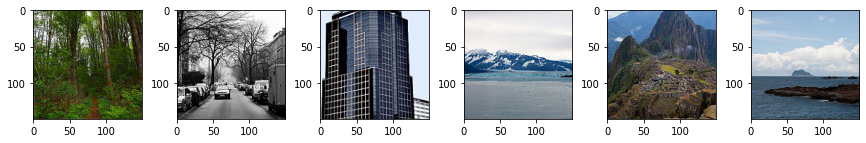

In [24]:
picture = [select_random_picture(os.path.join('train_filtered', 'bosques')),
           select_random_picture(os.path.join('train_filtered', 'calles')),
           select_random_picture(os.path.join('train_filtered', 'edificios')),
           select_random_picture(os.path.join('train_filtered', 'glaciares')),
           select_random_picture(os.path.join('train_filtered', 'montañas')),
           select_random_picture(os.path.join('train_filtered', 'mares'))]
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6, figsize=(15,2))

ax0.imshow(io.imread(picture[0]))
ax1.imshow(io.imread(picture[1]))
ax2.imshow(io.imread(picture[2]))
ax3.imshow(io.imread(picture[3])) 
ax4.imshow(io.imread(picture[4])) 
ax5.imshow(io.imread(picture[5]))       
plt.show(fig)

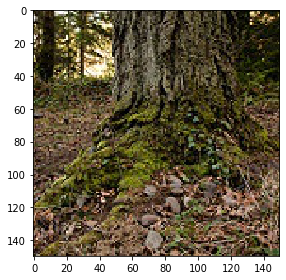

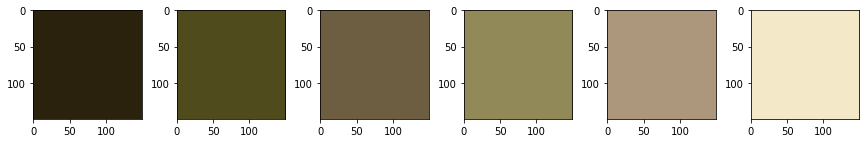

In [10]:
# Extract 6 colors from an image.
filename = select_random_picture(os.path.join('train_filtered', 'bosques'))
colors = colorgram.extract(filename, 6)
io.imshow(filename)
# colorgram.extract returns Color objects, which let you access
# RGB, HSL, and what proportion of the image was that color.
first_color = colors[0]
rgb = first_color.rgb # e.g. (255, 151, 210)
hsl = first_color.hsl # e.g. (230, 255, 203)
proportion  = first_color.proportion # e.g. 0.34

colors_list = sorted([(x.rgb[0],x.rgb[1],x.rgb[2]) for x in colors])

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6, figsize=(15,2))
ax0.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[0]))
ax1.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[1]))
ax2.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[2]))
ax3.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[3])) 
ax4.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[4])) 
ax5.imshow(np.ones(shape=(150,150,3), dtype=np.uint8)*np.uint8(colors_list[5]))         
plt.show(fig)

In [ ]:
palette = []
num_colors = 15

for img_class in target_dict:
  print(img_class)
  img_count = 0
  for jpg in os.listdir(f'train_filtered/{img_class}'):

    filename = f'train_filtered/{img_class}/{jpg}'

    img = io.imread(filename)
    average = img.mean(axis=1).mean(axis=0)
    #Filter Out gray scale images for color detection
    if abs(average[0]-average[1])+ abs(average[0]-average[2])+ abs(average[1]-average[2]) <= 2:
      continue

    try:
      colors_list = sorted([[x.rgb[0],x.rgb[1],x.rgb[2]] for x in colorgram.extract(filename, num_colors)])
    except:
      continue
    colors_list = np.append(np.array(colors_list).flatten(), target_dict[img_class])

    palette.append(colors_list)


columns = [x for x in range(num_colors*3)]+['class']
df_palette = pd.DataFrame(data=palette, columns=columns)
df_palette = df_palette.dropna()


edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
grid_params = {
    'max_depth': [10,30,100],
    'n_estimators': [100,300,1000]
}

gs_palette = GridSearchCV(
    RandomForestClassifier(),
    grid_params,
    n_jobs=-1,
    cv=3
)

rf_palette_gs = gs_palette.fit(df_palette.iloc[:,:-1],df_palette['class'])
print(rf_palette_gs.best_score_)
print(rf_palette_gs.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.5605538679415406
{'max_depth': 30, 'n_estimators': 1000}


In [ ]:
df_palette = pd.read_csv('Palette.csv', index_col=0)
df_palette.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_palette.iloc[:,:-1], df_palette['class'], test_size=0.33, random_state=random_state)
print('Fitting...')

rf_palette = RandomForestClassifier(max_depth=30,n_estimators=1000, n_jobs=-1, random_state=random_state)
rf_palette.fit(X_train, y_train)


Fitting...


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=1337, verbose=0,
                       warm_start=False)

In [ ]:
predictions = rf_palette.predict(X_test)
print("F1:",f1_score(y_test, predictions,average='macro'))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='macro'))
print("Recall:", recall_score(y_test, predictions, average='macro'))
confusion_matrix(y_test, predictions)

F1: 0.5587603494724713
Accuracy: 0.5626925811803745
Precision: 0.5585539053258041
Recall: 0.5613114560905582


array([[198,  43,  45,  93,  92, 194],
       [ 22, 541,   6,  24,  20,  56],
       [ 34,   4, 478, 158,  64,  12],
       [ 72,  17, 120, 455, 110,  31],
       [ 71,  15,  87, 118, 337,  63],
       [141,  40,  18,  34,  41, 365]])

## Conclusión:

Trabajar con el color de las imágenes es algo no trivial, puesto que para una misma categoría de imágenes se pueden encontrar gran cantidad de imágenes en colores diferentes de lo que se espera. Por esto mismo, hemos optado por realizar un estudio del color en base a los colores más frecuentes y el color promedio de la imagen. 

Aún así, se ha obtenido un buen resultado utilizando la paleta de colores de cada imagen obteniendo aproximadamente un 0.56 de f1_score.

# Ensemble Final (Blanco y Negro + Color)

Por último, realizaremos una votación entre el mejor modelo de blanco y negro (Gabor) y el mejor de color (Paleta de colores), para comprobar si esto produce una combinación que mejore los resultados.

In [ ]:
print('Testing...')

num_colors = 15
palette_preds = []
gabor_preds = []

test_preds = []

for img_class in target_dict:
  print(img_class)
  for jpg in os.listdir(f'test/{img_class}'):

      filename = f'test/{img_class}/{jpg}'

      img = io.imread(filename)

      if img.shape != (IMG_HEIGHT, IMG_WIDTH, 3):
        continue

      average = img.mean(axis=1).mean(axis=0)
      #Filter Out gray scale images for color detection
      
      if abs(average[0]-average[1])+ abs(average[0]-average[2])+ abs(average[1]-average[2]) > 2:
        colors_list = sorted([[x.rgb[0],x.rgb[1],x.rgb[2]] for x in colorgram.extract(filename, num_colors)])
        colors_list = np.array(colors_list).flatten()
        if len(colors_list) == num_colors*3:
          palette_preds_vote.append(rf_palette.predict([colors_list]))
          palette_preds.append(rf_palette.predict_proba([colors_list]))
        else:
          palette_preds.append(np.zeros(6))
      else:
        palette_preds.append(np.zeros(6))
      
      gabor_pred = np.array(filters.gabor(rgb2gray(img), 0.58)[0]).flatten()
      gabor_preds_vote.append(rf_grayscale_gabor.predict([gabor_pred]))
      gabor_preds.append(rf_grayscale_gabor.predict_proba([gabor_pred]))
      
      test_preds.append([target_dict[img_class]])


Testing...
edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
test_probs = [(palette_preds[i]+gabor_preds[i]).argmax() for i in range(len(test_preds))] 

print('F1:',f1_score(test_preds,test_probs, average='macro'))
print("Accuracy:", accuracy_score(test_preds, test_probs))
print("Precision:", precision_score(test_preds, test_probs, average='macro'))
print("Recall:", recall_score(test_preds, test_probs, average='macro'))
confusion_matrix(test_preds,test_probs)

F1: 0.6341562990019224
Accuracy: 0.6431673905780154
Precision: 0.6398234943543657
Recall: 0.63981200110147


array([[168,  29,  31,  63,  32, 114],
       [  7, 431,   2,   5,   1,  27],
       [  9,   7, 373, 103,  36,  21],
       [ 28,   4,  57, 346,  79,   9],
       [ 22,   8,  90, 105, 265,  20],
       [ 57,  63,  15,  10,  14, 342]])

---
# Conclusión final
Pese a trabajar en color, que supone un volumen de datos al menos 3 veces mayor (canales R,G y B), los resultados no parecen mejorar en exceso comparado con escala de grises. En efecto, el color era una característica muy importante en las fotos, pero no suficiente como para sobrevenir las insuficiencias de los modelos en sí.

El resultado obtenido por el ensemble utilizando el filtro gober y la paleta de colores, es sorprendentemente bueno comparado con cada modelo por individual, conseguidiendo un f1 score más aceptable. Esto se debe a que cada uno por sí mismo no genera una probabilidad de predicción segura para cada foto, mientras que realizando la suma de ambas probabilidades, se consigue tener mayor certeza del resultado.

Otros aspectos a tener en cuenta:

Creemos que al no tener ninguna influencia los vecinos del píxel que se analiza en cada momento en las decisiones de los modelos, éstos intentan encontrar similitudes en los píxeles en la posición i,j de cada imagen, en vez de observar "cúmulos" de píxeles como se haría en Deep Learning, identificando patrones o formas. Suponemos que es por esto que famosamente se suele hacer uso de modelos de esa familia, como son la Redes Neuronales, para la clasificación (y generación) de imágenes.


# Referencias


1. https://www.kaggle.com/hatone/randomforestclassifier-with-gridsearchcv
1. https://scikit-learn.org/stable/modules/
1. https://scikit-image.org/docs/0.12.x/api/skimage.filters.html
1. https://docs.python.org/3/library/random.html#random.randint
1. https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html
1. https://colab.research.google.com/drive/1B__sgkH_kDgz8yWsJAiAvGZjBr4V1GjL#scrollTo=xla3vBY47U10
1. https://towardsdatascience.com/color-palette-extraction-with-k-means-clustering-machine-learning-from-scratch-part-iv-55e807407e53


# Testing

In [ ]:
5/2

2.5

In [ ]:
round(5/2) # Floating point bs

2

In [ ]:
round(5.00000000000001/2) # Fixed

3

In [ ]:
# Initiate csv RGB DO NOT RERUN
with open("img_pixels.csv", 'w') as f:
    writer = csv.writer(f)
    data = [x for x in range(22500*3)] + ["class"]
    writer.writerow(data)

In [ ]:
# Load csv RGB DO NOT RERUN
for img_class in target_dict:
  print(img_class)
  img_count = 0
  for img in os.listdir(f'train/{img_class}'):
    if img_count == 100:
      break
    img_count += 1
    img_file = io.imread(f'train/{img_class}/{img}')
    value = np.asarray(img_file).flatten()
    value = np.append(value, target_dict[img_class])
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
# Initiate csv RGB TEST
with open("img_pixels_test.csv", 'w') as f:
    writer = csv.writer(f)
    data = [x for x in range(22500*3)] + ["class"]
    writer.writerow(data)

In [ ]:
# Load csv RGB TEST
for img_class in target_dict:
  print(img_class)
  img_count = 0
  for img in os.listdir(f'test/{img_class}'):
    if img_count == 100:
      break
    img_count += 1
    img_file = io.imread(f'test/{img_class}/{img}')
    value = np.asarray(img_file).flatten()
    value = np.append(value, target_dict[img_class])
    with open("img_pixels_test.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

edificios
bosques
glaciares
montañas
mares
calles


In [ ]:
df_img = pd.read_csv("img_pixels.csv")
df_img.head()

FileNotFoundError: ignored

In [ ]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

dirlist = [item for item in target_dict.keys()]
image = io.imread(select_random_picture(os.path.join('train', dirlist[0])))
image = np.array(image)
# label image regions
label_image = label(image)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
io.imshow(image)

ValueError: ignored

In [ ]:
X_train_array = np.array(X_train)
length = max(map(len, X_train))
#X_train_array = np.array([x+[None]*(length-len(x)) for x in X_train])
print(type(X_train_array[1]))
print(len(X_train_array[1]))
print(X_train_array[1].shape)
print(X_train_array[1])

print(type(X_train_array))
print(X_train_array.shape)
#print(X_train_array.reshape(14034, 22500))
print(np.unique([len(x) for x in X_train_array]))

<class 'numpy.ndarray'>
22500
(22500,)
[0.93646627 0.93646627 0.93646627 ... 0.         0.         0.        ]
<class 'numpy.ndarray'>
(13986, 22500)
[22500]


In [ ]:
#RandomForest GridSearch attempts
parameters = {
    'n_estimators'      : [10,100],
    'max_depth'         : [2,None],
    'random_state'      : [random_state],
    'criterion' :['gini', 'entropy'],
    'n_jobs': [-1]
}

In [ ]:
parameters = {
    'n_estimators' : [100,200],
    'max_depth' : [10,None],
    'random_state' : [random_state],
    'criterion' : ['gini', 'entropy'],
    'n_jobs': [-1]
}

In [ ]:
rf_grayscale_CV.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 1337}

In [ ]:
parameters = {
    'n_estimators' : [200, 300],
    'max_depth' : [15,None],
    'random_state' : [random_state],
    'criterion' : ['gini', 'entropy'],
    'n_jobs': [-1]
}

In [ ]:
rf_grayscale_CV.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 1337}